# Analysis code of DWPP real robot experiment

# import

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12


# Make reference path

In [252]:
def make_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    paths = []
    # 生成するカーブの角度パターン
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4]
    l_segment = 3.0  # 直線区間の長さパラメータ

    for theta in theta_list:
        # 1. 直進 (0 -> 1m)
        x1 = np.linspace(0, 1, 100)
        y1 = np.zeros_like(x1)
        
        # 2. 斜め直線 (角度thetaで長さl)
        # Note: 実際には直線補間だが、ここでは簡易的に生成
        x2 = np.linspace(1.0, 1.0 + l_segment * math.cos(theta), 300)
        y2 = np.linspace(0.0, l_segment * math.sin(theta), 300)
        
        # 3. 終端直進 (さらに3m進む)
        x3 = np.linspace(
            1.0 + l_segment * math.cos(theta), 
            4.0 + l_segment * math.cos(theta), 300)
        y3 = np.ones_like(x3) * l_segment * math.sin(theta)

        # 結合
        xs = np.concatenate([x1, x2, x3])
        ys = np.concatenate([y1, y2, y3])
        
        path = np.c_[xs, ys]
        
        paths.append(path)
        

    # 展開して返す
    return (paths[0], paths[1], paths[2])

PathA, PathB, PathC = make_path()
reference_path = {
    "PathA": PathA,
    "PathB": PathB,
    "PathC": PathC
}


# Load Data

In [253]:
dwpp_exp_dir = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp")
path_list = ["PathA", "PathB", "PathC"]
controller_list = ["PP", "APP", "RPP", "DWPP"]

# Analysis
- Velocity violation ratio
- Cross-track error RMSE
- Position Plot
- Velocity Plot

Velocity violation ratio

In [254]:
def calc_violation_rate(violation_flags) -> float:
    violation_count = np.sum(violation_flags)
    total_count = len(violation_flags)
    violation_rate = violation_count / total_count
    return violation_rate

Cross-track error RMSE

In [255]:
from scipy.spatial.distance import cdist

def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse


In [256]:
from collections import defaultdict
path_dict = defaultdict(lambda: defaultdict(list))
violation_rate_dict = defaultdict(lambda: defaultdict(list))
rmse_dict = defaultdict(lambda: defaultdict(list))

for path_name in path_list:
    for controller_name in controller_list:
        data_dir = dwpp_exp_dir / path_name / controller_name
        data_paths = list(data_dir.glob("*.csv"))
        
        for data_path in data_paths:
            df = pd.read_csv(data_path)
            print(f"Data from {data_path}:")
            
            # extract_data
            t = df["sec"].to_numpy() - df["sec"].to_numpy()[0]
            x = df["x"].to_numpy()
            y = df["y"].to_numpy()
            yaw = df["yaw"].to_numpy()
            v_real = df["v_real"].to_numpy()
            w_real = df["w_real"].to_numpy()
            v_cmd = df["v_cmd"].to_numpy()
            w_cmd = df["w_cmd"].to_numpy()
            v_nav = df["v_nav"].to_numpy()
            w_nav = df["w_nav"].to_numpy()
            
            velocity_violation = df["velocity_violation"].to_numpy()
            
            # record data
            path_dict[path_name][controller_name].append({"t": t, "x": x, "y": y, "yaw": yaw, "v_real": v_real, "w_real": w_real, "v_cmd": v_cmd, "w_cmd": w_cmd, "v_nav": v_nav, "w_nav": w_nav, "velocity_violation": velocity_violation})
            
            # analysis
            # velocity violation rate
            violation_rate = calc_violation_rate(velocity_violation)
            violation_rate_dict[path_name][controller_name].append(violation_rate)
            
            # RMSE
            robot_path = reference_path[path_name]
            recorded_path = np.c_[x, y]
            rmse = calc_rmse(robot_path, recorded_path)
            rmse_dict[path_name][controller_name].append(rmse)



Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/PP/Path A (45 deg)_PP_20251215_082606.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/PP/Path A (45 deg)_PP_20251215_083146.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/PP/Path A (45 deg)_PP_20251215_083228.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/PP/Path A (45 deg)_PP_20251215_083005.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/PP/Path A (45 deg)_PP_20251215_083057.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/APP/Path A (45 deg)_APP_20251215_083747.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/APP/Path A (45 deg)_APP_20251215_083413.csv:
Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/PathA/APP/Path A (45 deg)_APP_20251215_083700.csv:
Data from /home/de

# Velocity violation analysis

In [257]:
for path_name in path_list:
    for controller_name in controller_list:
        print(path_name, controller_name, np.mean(violation_rate_dict[path_name][controller_name]))

PathA PP 0.010818120351588911
PathA APP 0.03487459324699162
PathA RPP 0.0018518518518518517
PathA DWPP 0.0
PathB PP 0.13785554921838108
PathB APP 0.15752951289258635
PathB RPP 0.02921068202114203
PathB DWPP 0.0
PathC PP 0.44081262631467827
PathC APP 0.4102466769233314
PathC RPP 0.014468040570666058
PathC DWPP 0.0


# RMSE Analysis

In [258]:
for path_name in path_list:
    for controller_name in controller_list:
        print(path_name, controller_name, np.mean(rmse_dict[path_name][controller_name]))

PathA PP 0.1497422604584566
PathA APP 0.8223420190032282
PathA RPP 0.10955430195805962
PathA DWPP 0.12720790931135562
PathB PP 0.13399844663456656
PathB APP 0.1519221765992499
PathB RPP 0.12138015954100516
PathB DWPP 0.12445669683132217
PathC PP 0.5198145696272494
PathC APP 0.21105682782396076
PathC RPP 0.1574281926069902
PathC DWPP 0.15996678793765773


# Path Plot

一旦、一番初めの経路を描画してみる（なんなら、インデックスを指定して、それぞれ描画できるようにするとよいだろう）

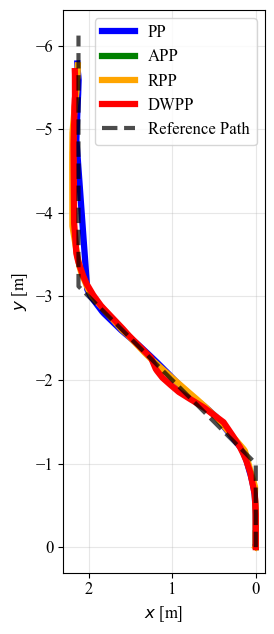

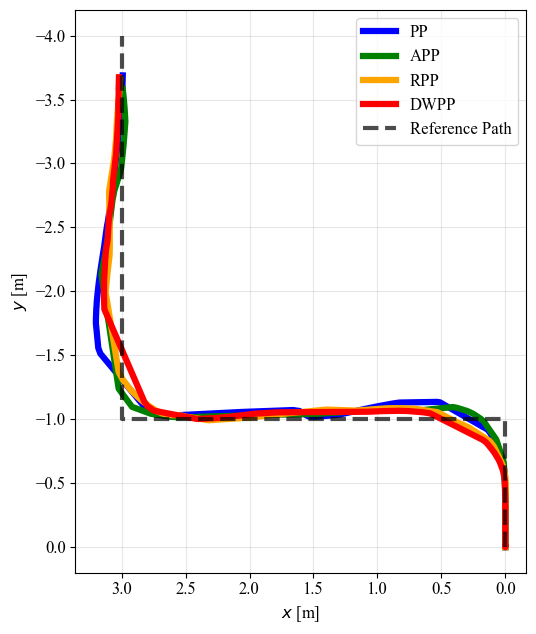

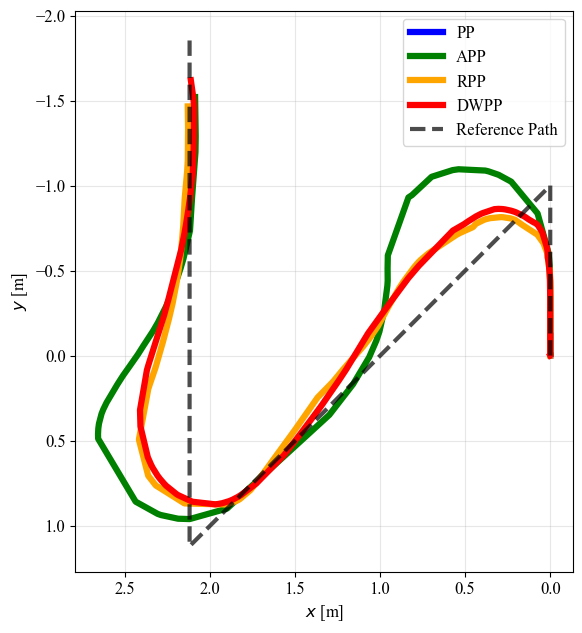

In [259]:
idx = 4
color_dict = {"PP": "blue", "APP": "green", "RPP": "orange", "DWPP": "red"}
for path_name in path_list:
    fig = plt.figure(figsize=(6.5,6.5))
    ax = fig.add_subplot(1, 1, 1)
    for controller_name in controller_list:
        data = path_dict[path_name][controller_name]
        
        x = data[idx]["x"]
        y = data[idx]["y"]
        # Plot robot trajectory (rotate: X->Y, Y->-X for X-up, Y-left coordinate system)
        ax.plot(y, [-x for x in x], color=color_dict[controller_name], label=controller_name, linewidth=4.5)

    robot_path = reference_path[path_name]
    ref_x = [point[0] for point in robot_path]
    ref_y = [point[1] for point in robot_path]
    ax.plot(ref_y, [-x for x in ref_x], 'k--', label='Reference Path', linewidth=3, alpha=0.7)
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')
    
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()
    plt.legend()
    
    plt.savefig(f'{path_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    

# Velocity plot

In [260]:
def plot_velocity_profile(t, v_real, w_real, v_cmd, w_cmd, path_name, controller_name):
    # Create subplots for translational and rotational velocities (horizontal layout)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # Plot translational velocity
    ax1.plot(t, v_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
    ax1.plot(t, v_real, '-', color='blue', label='Actual', linewidth=3)
    # Add velocity limit line
    ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')

    # Plot rotational velocity
    ax2.plot(t, w_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
    # ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
    ax2.plot(t, w_real, '-', color='blue', label='Actual', linewidth=3)
    # Add velocity limit lines
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')
    ax2.axhline(y=-1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Min Velocity')

    # Set labels and legends
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Linear Velocity [m/s]')
    # ax1.set_yticks([0, 0.10, 0.20])
    ax1.grid(True, alpha=0.3)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Angular Velocity [rad/s]')
    # ax2.set_ylim(-0.7, 0.7)
    # ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax2.grid(True, alpha=0.3)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'{path_name}_{controller_name}_velocity_profile.png', dpi=300, bbox_inches='tight')
    plt.show()
    

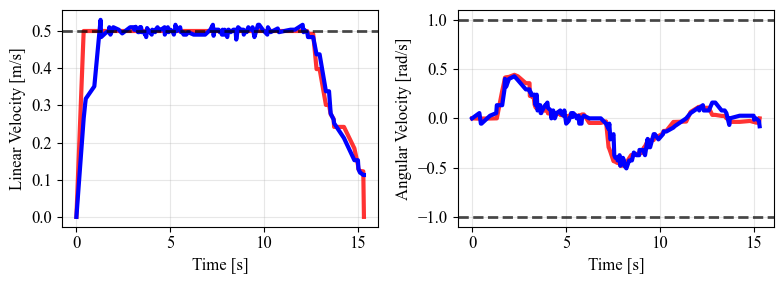

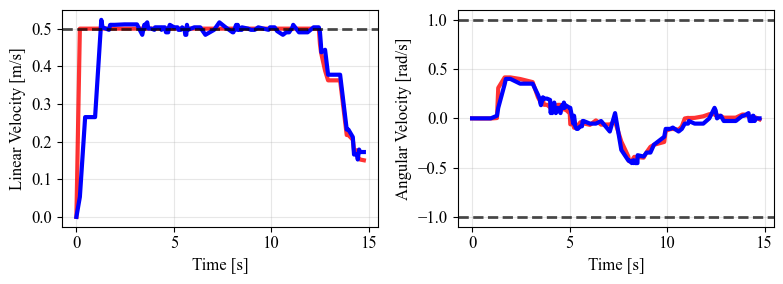

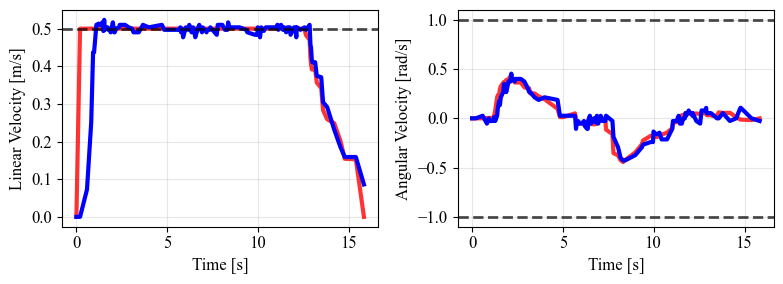

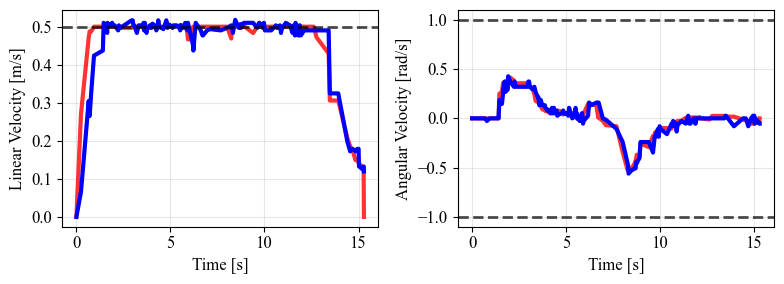

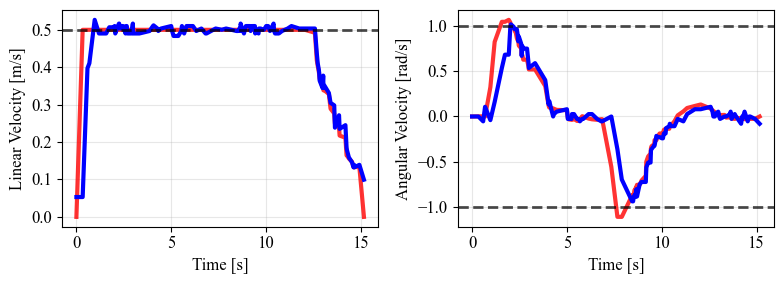

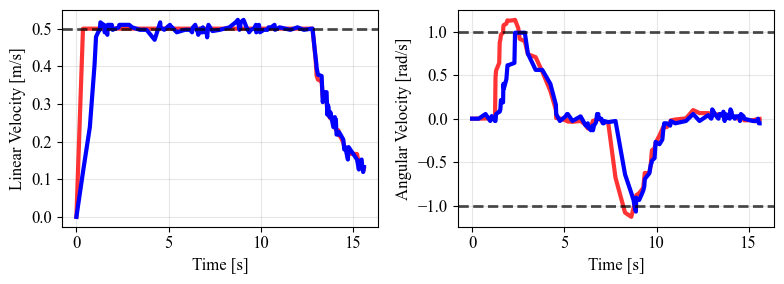

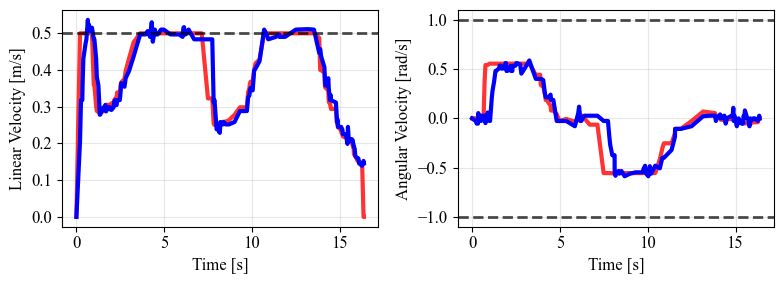

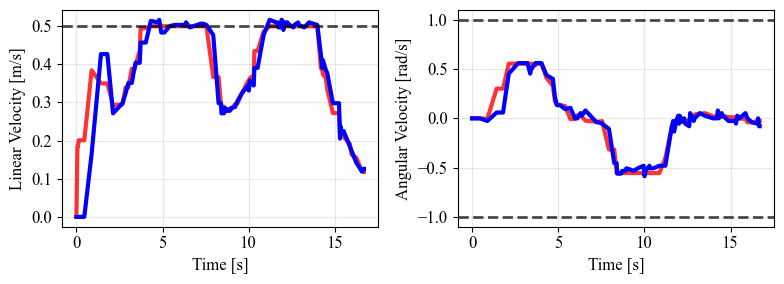

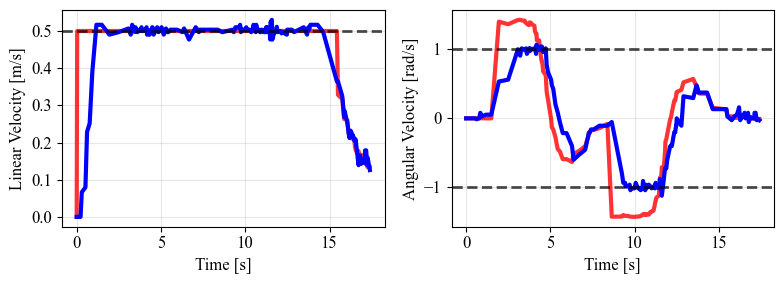

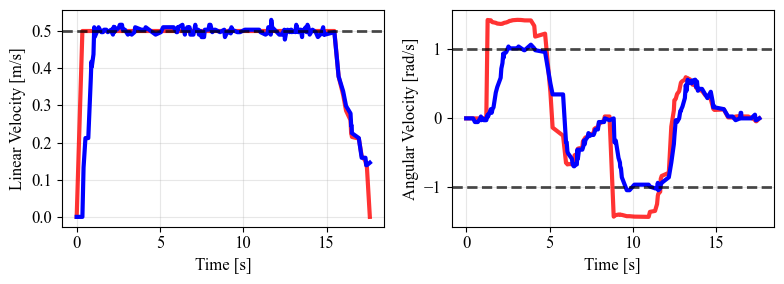

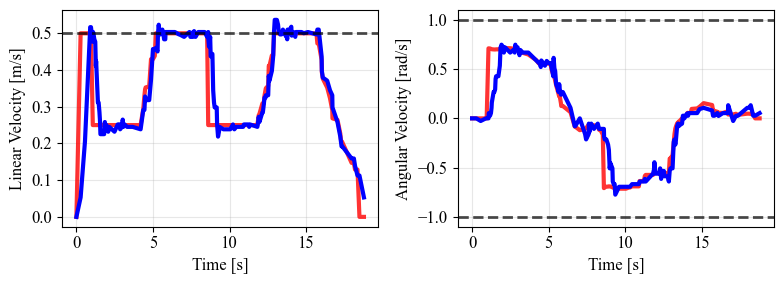

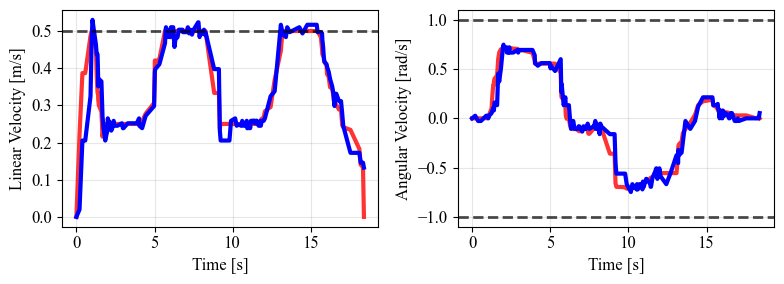

In [261]:
idx = 1
color_dict = {"PP": "blue", "APP": "green", "RPP": "orange", "DWPP": "red"}
for path_name in path_list:
    for controller_name in controller_list:
        data = path_dict[path_name][controller_name]
        
        t = data[idx]["t"]
        
        v_real = data[idx]["v_real"]
        w_real = data[idx]["w_real"]
        
        v_cmd = data[idx]["v_cmd"]
        w_cmd = data[idx]["w_cmd"]
        
        # Create subplots for translational and rotational velocities (horizontal layout)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

        # Plot translational velocity
        ax1.plot(t, v_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
        ax1.plot(t, v_real, '-', color='blue', label='Actual', linewidth=3)
        # Add velocity limit line
        ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')

        # Plot rotational velocity
        ax2.plot(t, w_cmd, '-', color='red', label='Reference', linewidth=3, alpha=0.8)
        # ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
        ax2.plot(t, w_real, '-', color='blue', label='Actual', linewidth=3)
        # Add velocity limit lines
        ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')
        ax2.axhline(y=-1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Min Velocity')

        # Set labels and legends
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('Linear Velocity [m/s]')
        # ax1.set_yticks([0, 0.10, 0.20])
        ax1.grid(True, alpha=0.3)
        # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('Angular Velocity [rad/s]')
        # ax2.set_ylim(-0.7, 0.7)
        # ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
        ax2.grid(True, alpha=0.3)
        # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.savefig(f'{path_name}_{controller_name}_velocity_profile.png', dpi=300, bbox_inches='tight')
        plt.show()
    

# Dynamic Window Analysis

In [262]:
def divide_df_to_segments(df: pd.DataFrame, t_threshold: float) -> list:
    """
    Divide the DataFrame into segments based on time gaps exceeding the threshold.
    
    Args:
        df (pd.DataFrame): Input DataFrame with a 'timestamp' column.
        t_threshold (float): Time gap threshold to identify segments.
        
    Returns:
        list: List of DataFrame segments.
    """
    t = df["timestamp"].to_numpy()
    
    # diffをとる
    t_diff = np.diff(t, prepend=t[0])
    
    # diffが閾値以上のindexでcsvを分割する
    split_indices = np.where(t_diff >= t_threshold)[0]
    
    # split_indices から各区間を作成
    split_points = np.r_[0, split_indices, len(df)]
    segments = []
    for start, end in zip(split_points[:-1], split_points[1:]):
        segment = df.iloc[start:end].copy()
        if not segment.empty:
            segments.append(segment)
    
    print(f"Found {len(segments)} segments (threshold={t_threshold})")
    for i, segment in enumerate(segments):
        span = segment["timestamp"].iloc[-1] - segment["timestamp"].iloc[0]
        print(f" segment {i}: rows={len(segment)}, span={span:.3f}s")
    
    return segments



In [263]:
import os

def plot_dynamic_window(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs, path_name, controller_name):
    base_dir = '/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow'
    os.makedirs(f'{base_dir}/{path_name}/{controller_name}', exist_ok=True)
    
    for idx, (curvature, v, w, next_v, next_w, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg) \
        in enumerate(zip(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs)):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        
        # Dynamic Windowの範囲を四角形でプロット
        vertexes = [
            (dw_min_v, dw_min_w),
            (dw_min_v, dw_max_w),
            (dw_max_v, dw_max_w),
            (dw_max_v, dw_min_w)
        ]
        rectangle = patches.Polygon(vertexes, closed=True, fill=False, color='black', alpha=1.0, label='Dynamic Window')
        ax.add_patch(rectangle)
        
        # omega = curvature * v の直線をプロット
        v_list = np.linspace(-0.1, 0.6, 100)
        omega_line = curvature * v_list
        ax.plot(v_list, omega_line, 'g--', label='ω = k * v')
        
        # 現在の速度点
        ax.scatter(v, w, s=12, color='blue', label='Current Velocity')
        # 速度指令値の速度点
        ax.scatter(next_v, next_w, s=12, color='red', label='Command Velocity')
        # 制御後の速度点
        ax.scatter(actual_v, actual_w, s=12, color='magenta', label='Actual Velocity')
        
        # v_regの描画
        ax.axvline(x=v_reg, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Regulated Velocity')
        
        ax.set_xlabel('Linear Velocity [m/s]')
        ax.set_ylabel('Angular Velocity [rad/s]')
        ax.set_xlim(-0.1, 0.6)
        ax.set_ylim(-1.2, 1.2)
        ax.grid(True, alpha=0.3)
        # ax.set_aspect('equal')
        # plt.legend()
        plt.savefig(f'{base_dir}/{path_name}/{controller_name}/{idx}.png', dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close()
    

In [264]:
def data_analysis(segment, path_name, controller_name):
    # data aquisition
    timestamp = segment["timestamp"].to_numpy() - segment["timestamp"].to_numpy()[0]
    curvature = segment["curvature"].to_numpy()
    v = segment["current_linear_vel"].to_numpy()
    w = segment["current_angular_vel"].to_numpy()
    next_v = segment["next_linear_vel"].to_numpy()
    next_w = segment["next_angular_vel"].to_numpy()
    dw_max_v = segment["dw_max_linear_vel"].to_numpy()
    dw_max_w = segment["dw_max_angular_vel"].to_numpy()
    dw_min_v = segment["dw_min_linear_vel"].to_numpy()
    dw_min_w = segment["dw_min_angular_vel"].to_numpy()
    actual_v = segment["actual_linear_vel"].to_numpy()
    actual_w = segment["actual_angular_vel"].to_numpy()
    v_reg = segment["regulated_linear_velocity"].to_numpy()
    
    # plot velocity profile
    plot_velocity_profile(timestamp, actual_v, actual_w, next_v, next_w, path_name, controller_name)
    
    # plot dynamic window
    plot_dynamic_window(curvature, v, w, next_v, next_w, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg, path_name, controller_name)

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathA_PP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=448, span=14.899s
 segment 1: rows=453, span=15.066s
 segment 2: rows=455, span=15.133s
 segment 3: rows=463, span=15.400s
 segment 4: rows=451, span=14.999s


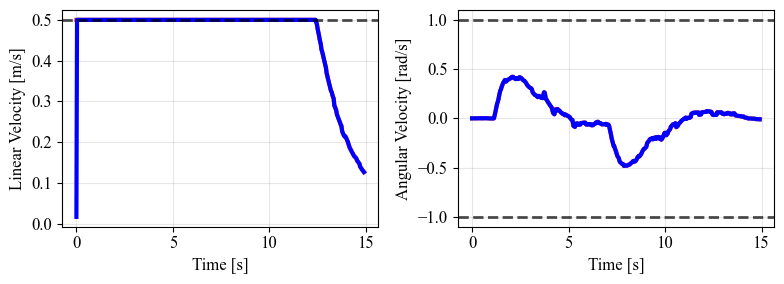

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathA_APP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=448, span=14.899s
 segment 1: rows=453, span=15.066s
 segment 2: rows=458, span=15.233s
 segment 3: rows=452, span=15.033s
 segment 4: rows=459, span=15.266s


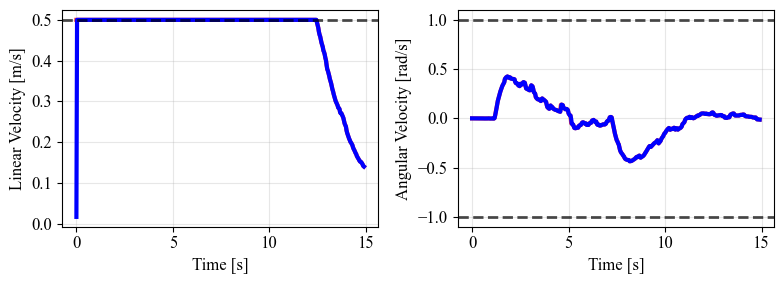

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathA_RPP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=460, span=15.299s
 segment 1: rows=458, span=15.233s
 segment 2: rows=459, span=15.267s
 segment 3: rows=458, span=15.233s
 segment 4: rows=456, span=15.166s


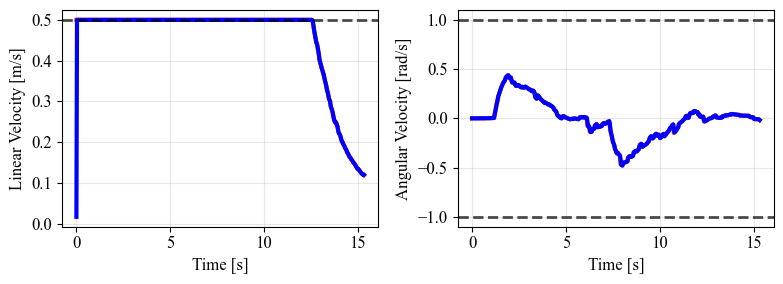

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathA_DWPP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=468, span=15.566s
 segment 1: rows=467, span=15.533s
 segment 2: rows=450, span=14.966s
 segment 3: rows=459, span=15.266s
 segment 4: rows=457, span=15.199s


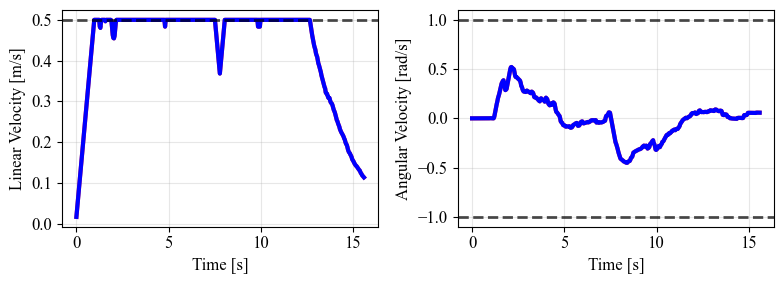

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathB_PP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=463, span=15.399s
 segment 1: rows=456, span=15.166s
 segment 2: rows=454, span=15.099s
 segment 3: rows=463, span=15.400s
 segment 4: rows=450, span=14.966s


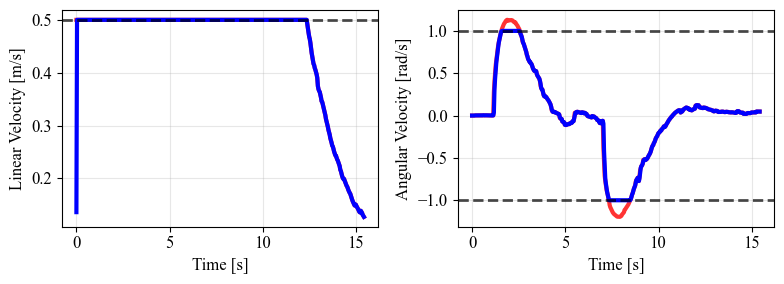

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathB_APP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=455, span=15.133s
 segment 1: rows=462, span=15.366s
 segment 2: rows=463, span=15.399s
 segment 3: rows=468, span=15.566s
 segment 4: rows=453, span=15.066s


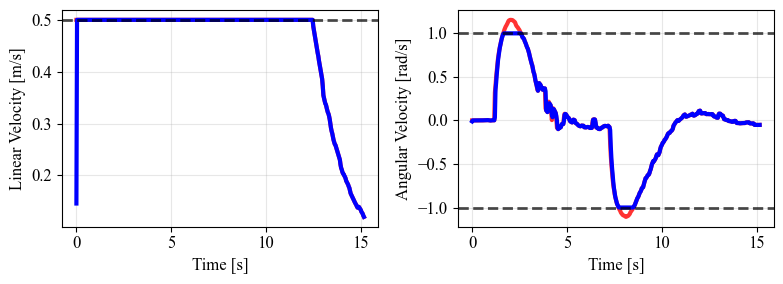

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathB_RPP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=496, span=16.500s
 segment 1: rows=507, span=16.866s
 segment 2: rows=504, span=16.766s
 segment 3: rows=505, span=16.799s
 segment 4: rows=489, span=16.266s


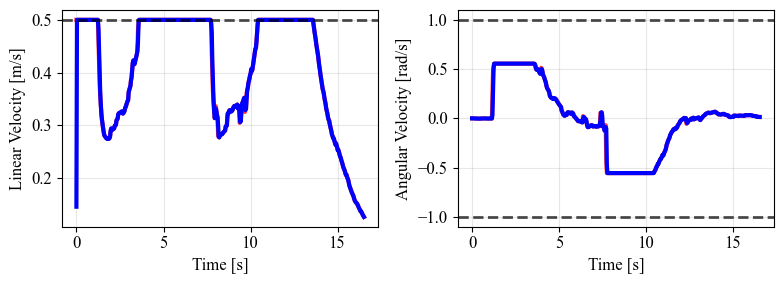

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathB_DWPP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=500, span=16.633s
 segment 1: rows=501, span=16.666s
 segment 2: rows=506, span=16.833s
 segment 3: rows=487, span=16.199s
 segment 4: rows=505, span=16.800s


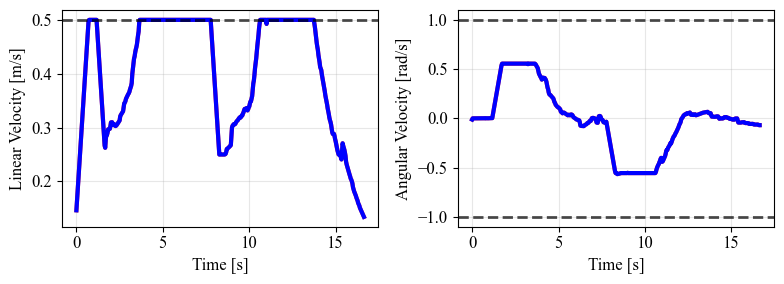

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathC_PP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=521, span=17.333s
 segment 1: rows=519, span=17.266s
 segment 2: rows=514, span=17.099s
 segment 3: rows=519, span=17.266s
 segment 4: rows=504, span=16.766s


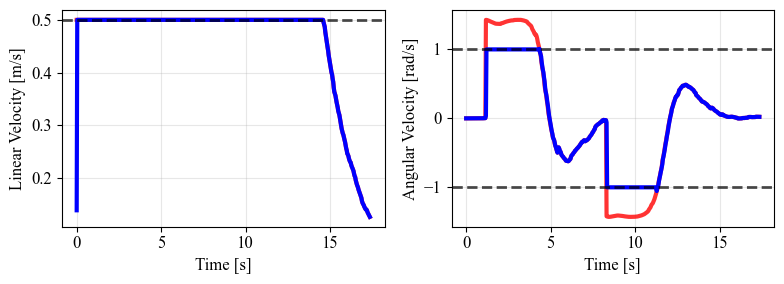

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathC_APP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=522, span=17.366s
 segment 1: rows=507, span=16.866s
 segment 2: rows=526, span=17.499s
 segment 3: rows=520, span=17.299s
 segment 4: rows=523, span=17.399s


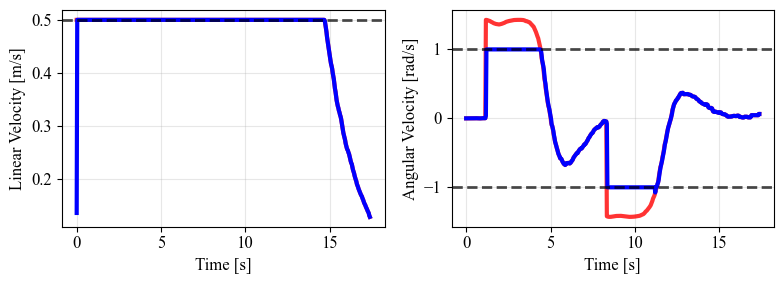

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathC_RPP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=559, span=18.599s
 segment 1: rows=550, span=18.300s
 segment 2: rows=545, span=18.132s
 segment 3: rows=562, span=18.699s
 segment 4: rows=551, span=18.332s


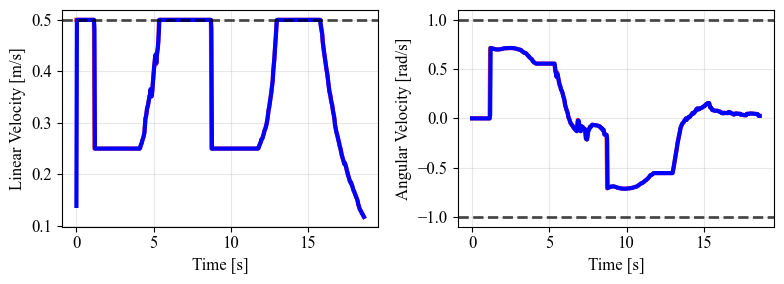

Data from /home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow/PathC_DWPP.csv:
Found 5 segments (threshold=1.0)
 segment 0: rows=552, span=18.366s
 segment 1: rows=557, span=18.533s
 segment 2: rows=555, span=18.466s
 segment 3: rows=555, span=18.466s
 segment 4: rows=557, span=18.532s


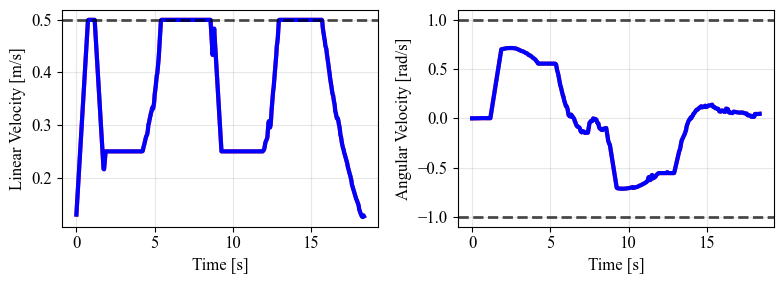

In [265]:
dw_dir_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow")
path_list = ["PathA", "PathB", "PathC"]
controller_list = ["PP", "APP", "RPP", "DWPP"]
data_dict = defaultdict(lambda: defaultdict(list))
idx = 0

for path in path_list:
    for controller in controller_list:
        data_path = dw_dir_path / f"{path}_{controller}.csv"
        df = pd.read_csv(data_path)
        print(f"Data from {data_path}:")

        df = pd.read_csv(data_path)
        t_threshold = 1.0  # seconds
        segments = divide_df_to_segments(df, t_threshold)
        
        # 各走行データ
        segment = segments[idx]
        data_analysis(segment, path, controller)
        

t_diffの統計量確認

In [266]:
t_segment = segments[0]["timestamp"].to_numpy() - segments[0]["timestamp"].to_numpy()[0]
t_segment_diff = np.diff(t_segment, prepend=t_segment[0])

t_diff_avg = np.mean(t_segment_diff)
t_diff_std = np.std(t_segment_diff)
t_diff_max = np.max(t_segment_diff)
t_diff_min = np.min(t_segment_diff)

print(t_diff_avg, t_diff_std, t_diff_max, t_diff_min)

0.033270961996437844 0.0014456265026251622 0.034227848052978516 0.0


めっちゃ安定してて神

In [267]:
t_segment_diff

array([0.        , 0.03294301, 0.03371286, 0.03326011, 0.03283191,
       0.03401709, 0.03313208, 0.03270102, 0.03397393, 0.03294802,
       0.03361988, 0.03330517, 0.0333178 , 0.03292298, 0.03340721,
       0.03318095, 0.0333209 , 0.03411412, 0.03274584, 0.03318119,
       0.03333092, 0.03389788, 0.03284001, 0.03321719, 0.03372288,
       0.03345609, 0.03354788, 0.03327894, 0.03295016, 0.03358698,
       0.03343606, 0.03303981, 0.03294921, 0.03340101, 0.03356886,
       0.03365493, 0.03328609, 0.03282094, 0.03332496, 0.03379703,
       0.03292608, 0.03390598, 0.03260398, 0.033324  , 0.033885  ,
       0.033283  , 0.03286409, 0.033777  , 0.033391  , 0.03308487,
       0.03324509, 0.03357005, 0.03338599, 0.03345203, 0.03285885,
       0.0331831 , 0.03377795, 0.03332305, 0.03341389, 0.03328013,
       0.03289485, 0.03392911, 0.03320003, 0.03300691, 0.03347015,
       0.03350401, 0.03290677, 0.0335691 , 0.03313708, 0.03320885,
       0.03419304, 0.03250313, 0.03381085, 0.03291202, 0.03324

## セグメントを選択してDWの範囲と速度を可視化


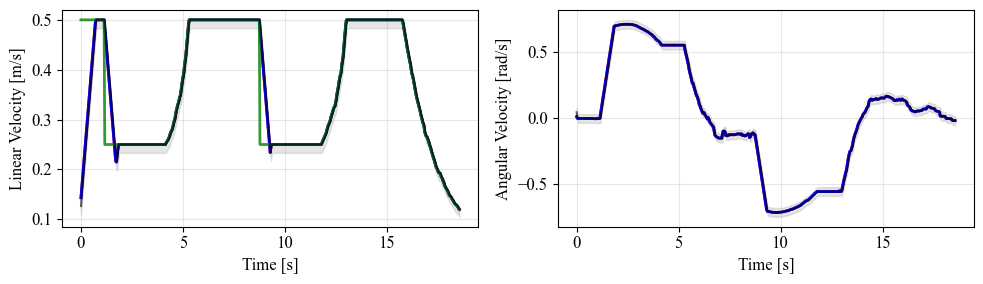

In [268]:
seg_idx = 1  # 必要に応じて変更
seg = segments[seg_idx]
t_seg = seg["timestamp"].to_numpy()
t_seg = t_seg - t_seg[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.fill_between(t_seg, seg["dw_min_linear_vel"], seg["dw_max_linear_vel"],
                 color="gray", alpha=0.2, label="DW bounds")
ax1.plot(t_seg, seg["next_linear_vel"], color="red", linewidth=2, label="Next")
ax1.plot(t_seg, seg["actual_linear_vel"], color="blue", linewidth=2, label="Actual")
ax1.plot(t_seg, seg["regulated_linear_velocity"], color="green", linewidth=2, alpha=0.8, label="Regulated")
ax1.plot(t_seg, seg["current_linear_vel"], color="black", linewidth=1.5, alpha=0.6, label="Current")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Linear Velocity [m/s]")
ax1.grid(True, alpha=0.3)

ax2.fill_between(t_seg, seg["dw_min_angular_vel"], seg["dw_max_angular_vel"],
                 color="gray", alpha=0.2, label="DW bounds")
ax2.plot(t_seg, seg["next_angular_vel"], color="red", linewidth=2, label="Next")
ax2.plot(t_seg, seg["actual_angular_vel"], color="blue", linewidth=2, label="Actual")
ax2.plot(t_seg, seg["current_angular_vel"], color="black", linewidth=1.5, alpha=0.6, label="Current")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Angular Velocity [rad/s]")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
